In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Функции

In [261]:
def data_load():
    df = pd.read_excel('/Users/nkt1lyn/coef_opr_actions.xlsx')
    return df

def data_shape(df, date1, date2):
    df = df.loc[(df['Time'] >= date1) & (df['Time'] <= date2)]
    return df

def shift_model(df, l):
    l = -l
    df['Период'] = np.roll(df['Период'], l)
    # df = pd.concat([df.iloc[l:], df.iloc[:l]], ignore_index=True)
    if l > 0:
        df.loc[:l-1, 'Период'] = 1
    elif l == 0:
      return df
    else:
      df.iloc[l:, df.columns.get_loc('Период')] = 13
    return df

def day_cat(df):
    df['Категория дня'] = np.where((df['Var1'] >= mean - std) & (df['Var1'] <= mean + std), 'White', 'Black').astype(str)
    return df

def model_with_shift(l):
    df = data_load()
    df = data_shape(df, '2019-12-21', '2023-03-04')
    df = day_cat(df)
    df['Период'] = (df['Time'].sub(df['Time'].min()) // pd.Timedelta('90 days')).add(1)
    df = shift_model(df, l)
    return df

def calculate_levels(group):
   Std1 = (group['Var1'] >= mean - std) & (group['Var1'] <= mean + std)

   W = Std1.sum()
   B = len(group) - W

   BL1 = 100 * W / len(group)
   BL2 = 100 * B / len(group)

   return pd.Series({'Период': group['Период'].iloc[0], 'BW': [BL1, BL2]})

def BW_calc(df):
    result = df.groupby('Период').apply(calculate_levels).reset_index(drop=True)
    W = result['BW'].apply(lambda x: x[0]).sum()/len(result)
    B = result['BW'].apply(lambda x: x[1]).sum()/len(result)
    return [W, B]


In [262]:
def plot_shift(df, l):
    result_df = df.groupby('Период').apply(calculate_levels).reset_index(drop=True)
    bar_width = 0.4
    bar_positions1 = result_df['Период'].values
    bar_positions2 = bar_positions1 + bar_width

    fig, ax = plt.subplots(figsize=(16, 6))
    bar1 = ax.bar(bar_positions1, [val[0] for val in result_df['BW']], width=bar_width, color='white', edgecolor='black', label='Белые дни')
    bar2 = ax.bar(bar_positions2, [val[1] for val in result_df['BW']], width=bar_width, color='black', edgecolor='black', label='Черные дни')

    for i, (bw_values, period) in enumerate(zip(result_df['BW'], result_df['Период'])):
        ax.text(bar_positions1[i], bw_values[0] + 1, f'{bw_values[0]:.2f}', ha='center', va='bottom', fontsize=7)
        ax.text(bar_positions2[i], bw_values[1] + 1, f'{bw_values[1]:.2f}', ha='center', va='bottom', fontsize=7)

    ax.set_xticks(bar_positions1 + bar_width / 2)
    ax.set_xticklabels(result_df['Период'])
    ax.legend()

    # Добавление подписей осей и заголовка
    ax.set_xlabel('Паттерн модели с параметром сдвига l = ' + str(l))
    ax.set_ylabel('Уровени белого и черного в (%)')

    plt.show()

In [263]:

df = data_load()
df = data_shape(df, '2019-12-21', '2023-03-04')
mean = df['Var1'].mean()
std = df['Var1'].std()
Std1 = (df['Var1'] >= mean - std) & (df['Var1'] <= mean + std)


In [264]:

W = Std1.sum()
B = len(df) - W

BL1 = 100 * W / len(df)
BL2 = 100 * B / len(df)

BL = [BL1, BL2]
BL


[71.02564102564102, 28.974358974358974]

In [265]:
def fit_error_calc(BW, BL = BL):
    fit_error = np.linalg.norm([BW[0]-BL[0], BW[1]-BL[1]])
    return fit_error


In [266]:
def FE_table(list):
    model = []
    fit_error = []
    
    for l in list:
        model.append(l)
        fit_error.append(fit_error_calc(BW_calc(model_with_shift(l))).round(4))

    FE = pd.DataFrame({
        'Model, l': model,
        'Fit-error': fit_error
        })
    return FE

In [267]:
def WB_list(models):
    W_list = []
    B_list = []
    for l in list(models.keys()):
        result = models[l].groupby('Период').apply(calculate_levels).reset_index(drop=True)
        bw_list = result['BW'].tolist()
        W_list.append([sublist[0] for sublist in bw_list])
        B_list.append([sublist[1] for sublist in bw_list])
    return W_list, B_list

In [268]:
def WсBc(W_list, B_list):
    zipped_list = zip(*W_list)
    Wc_list = [(sum(item)/len(W_list)).round(4) for item in zipped_list]

    zipped_list = zip(*B_list)
    Bc_list = [(sum(item)/len(B_list)).round(4) for item in zipped_list]

    return Wc_list, Bc_list

In [269]:
def BWc_list(Wc, Bc):
    return [np.mean(Wc).round(4), np.mean(Bc).round(4)]

In [270]:
def fit_error_c(BWc, BL):
    return np.linalg.norm([BWc[0]-BL[0], BWc[1]-BL[1]]).round(4)

In [271]:
models = {}
for l in range(-40, 41):
    models[l] = model_with_shift(l)

In [272]:
W_list, B_list = WB_list(models)
Wc_list, Bc_list = WсBc(W_list, B_list)

In [273]:
FE = FE_table([l for l in range(-40, 41)])

In [274]:
from sklearn.metrics import r2_score
result = models[0].groupby('Период').apply(calculate_levels).reset_index(drop=True)
bw_list = result['BW'].tolist()
ytrue = [sublist[0] for sublist in bw_list]
r2_values = []
for l in range(-40, 41):
    result = models[l].groupby('Период').apply(calculate_levels).reset_index(drop=True)
    bw_list = result['BW'].tolist()
    ypred = [sublist[0] for sublist in bw_list]
    r2_values.append((1 - r2_score(ytrue, ypred)).round(4))

FE['dist between models = 1 - R^2'] = r2_values

In [275]:
ytrue = Wc_list
r2_values = []
for l in range(-40, 41):
    result = models[l].groupby('Период').apply(calculate_levels).reset_index(drop=True)
    bw_list = result['BW'].tolist()
    ypred = [sublist[0] for sublist in bw_list]
    r2_values.append(r2_score(ytrue, ypred).round(4))

FE['R^2 to centroid'] = r2_values

In [276]:
FE

,"Model, l",Fit-error,dist between models = 1 - R^2,R^2 to centroid
0,-40,0.7885,0.4343,0.6685
1,-39,0.7158,0.4062,0.7008
2,-38,0.7370,0.4312,0.6710
3,-37,0.7202,0.4183,0.6802
4,-36,0.7367,0.4575,0.6529
...,...,...,...,...
76,36,0.2187,0.1865,0.8872
77,37,0.2651,0.2178,0.8753
78,38,0.1905,0.2143,0.8745
79,39,0.2386,0.2583,0.8463


In [277]:
models = {}
for l in range(-40, 41):
    models[l] = model_with_shift(l)
W_list, B_list = WB_list(models)
Wc_list, Bc_list = WсBc(W_list, B_list)
BWc = BWc_list(Wc_list, Bc_list)
fit_error_global_centroid = fit_error_c(BWc, BL)
fit_error_global_centroid

0.0767

# Первый центроид

In [278]:
threshold = FE['R^2 to centroid'].mean()
threshold

0.8924098765432099

In [279]:
centroid_1 = FE[FE['R^2 to centroid'] > threshold]

print("Количество отобранных моделей:", len(centroid_1))

Количество отобранных моделей: 54


In [280]:
models = {}
for l in centroid_1['Model, l'].to_list():
    models[l] = model_with_shift(l)

In [281]:
W_list, B_list = WB_list(models)
Wc_list, Bc_list = WсBc(W_list, B_list)


In [282]:
BWc = BWc_list(Wc_list, Bc_list)
BWc

[71.0238, 28.9762]

In [283]:
fit_error_centroid_1 = fit_error_c(BWc, BL)
fit_error_centroid_1

0.0026

In [284]:
ytrue = Wc_list

r2_values = []
for l in models:
    result = models[l].groupby('Период').apply(calculate_levels).reset_index(drop=True)
    bw_list = result['BW'].tolist()
    ypred = [sublist[0] for sublist in bw_list]
    r2_values.append(r2_score(ytrue, ypred).round(4))

centroid_1.loc[:, 'R^2 to new centroid'] = r2_values

/var/folders/lr/pb6gq9k51rx3x93_dcbnvjmr0000gn/T/ipykernel_7061/77566535.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  centroid_1.loc[:, 'R^2 to new centroid'] = r2_values


In [285]:
centroid_1

,"Model, l",Fit-error,dist between models = 1 - R^2,R^2 to centroid,R^2 to new centroid
13,-27,0.3028,0.1478,0.8926,0.8704
14,-26,0.2912,0.1226,0.9010,0.8838
15,-25,0.2789,0.1117,0.9148,0.9006
16,-24,0.2660,0.0881,0.9389,0.9238
17,-23,0.2111,0.0839,0.9486,0.9330
18,-22,0.1997,0.0765,0.9527,0.9386
19,-21,0.1879,0.0565,0.9655,0.9548
20,-20,0.1758,0.0330,0.9685,0.9686
21,-19,0.1635,0.0305,0.9494,0.9584
22,-18,0.1712,0.0318,0.9486,0.9568


# Задание 10

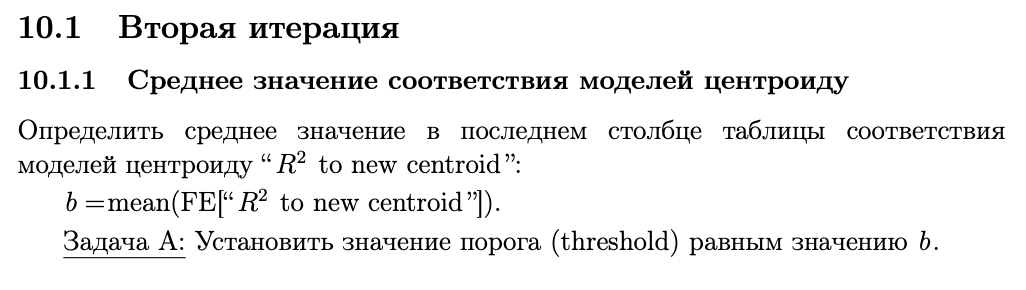

In [286]:
threshold = centroid_1['R^2 to new centroid'].mean()
threshold

0.9479981481481482

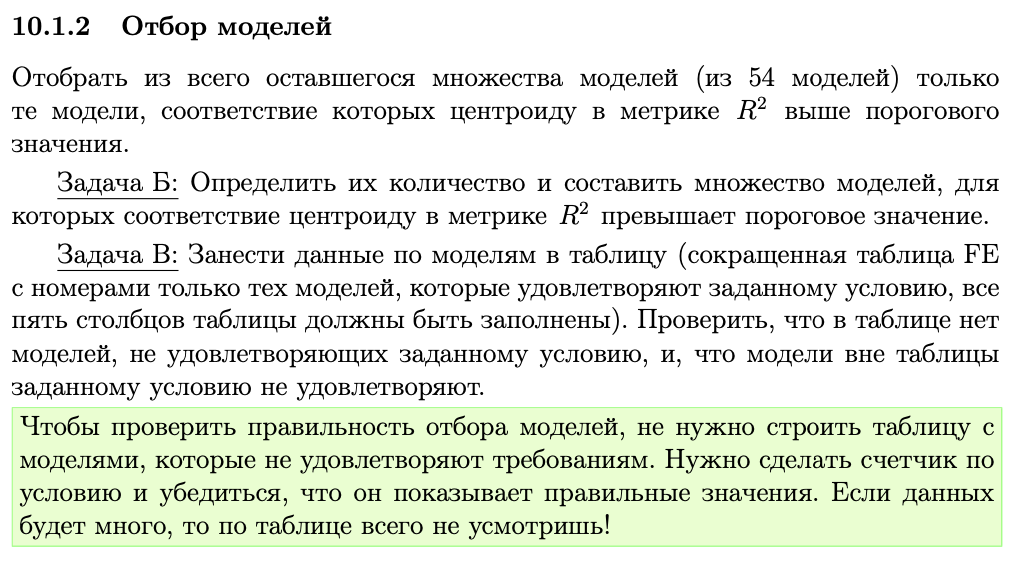

In [287]:
centroid_2 = centroid_1[centroid_1['R^2 to new centroid'] > threshold]

print("Количество отобранных моделей:", len(centroid_2))

Количество отобранных моделей: 34


In [288]:
other_models = centroid_1[centroid_1['R^2 to new centroid'] <= threshold]
print("Количество не удовлетворяющих моделей:", len(other_models))

Количество не удовлетворяющих моделей: 20


In [289]:
models = {}
for l in centroid_2['Model, l'].to_list():
    models[l] = model_with_shift(l)

In [290]:
centroid_2

,"Model, l",Fit-error,dist between models = 1 - R^2,R^2 to centroid,R^2 to new centroid
19,-21,0.1879,0.0565,0.9655,0.9548
20,-20,0.1758,0.0330,0.9685,0.9686
21,-19,0.1635,0.0305,0.9494,0.9584
22,-18,0.1712,0.0318,0.9486,0.9568
23,-17,0.1578,0.0234,0.9516,0.9587
24,-16,0.1445,0.0182,0.9385,0.9538
35,-5,0.0180,0.0158,0.9173,0.9554
36,-4,0.0179,0.0098,0.9213,0.9566
37,-3,0.0161,0.0111,0.9140,0.9522
38,-2,0.0099,0.0055,0.9245,0.9582


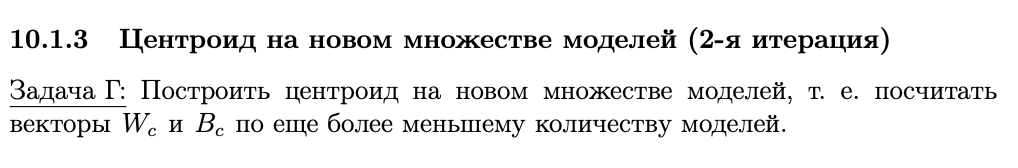

In [291]:
W_list, B_list = WB_list(models)
Wc_list, Bc_list = WсBc(W_list, B_list)

In [292]:
Wc_list


[64.1077,
 50.8497,
 72.8105,
 67.3203,
 83.268,
 81.6013,
 81.8301,
 63.4967,
 68.4967,
 71.8954,
 80.0327,
 68.2026,
 69.308]

In [293]:
Bc_list

[35.8923,
 49.1503,
 27.1895,
 32.6797,
 16.732,
 18.3987,
 18.1699,
 36.5033,
 31.5033,
 28.1046,
 19.9673,
 31.7974,
 30.692]

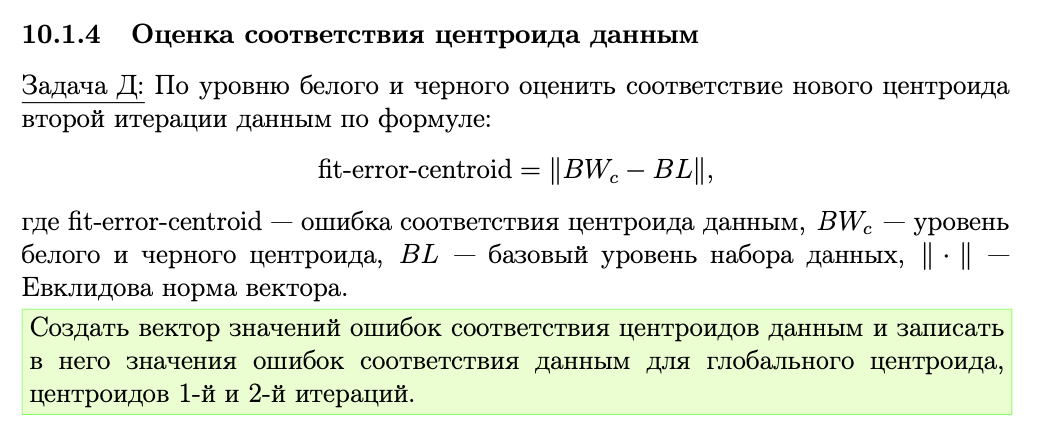

In [294]:
BWc = BWc_list(Wc_list, Bc_list)
BWc

[71.0169, 28.9831]

In [295]:
fit_error_centroid_2 = fit_error_c(BWc, BL)
fit_error_centroid_2

0.0124

In [296]:
fit_error_vec = [fit_error_global_centroid, fit_error_centroid_1, fit_error_centroid_2]
fit_error_vec

[0.0767, 0.0026, 0.0124]

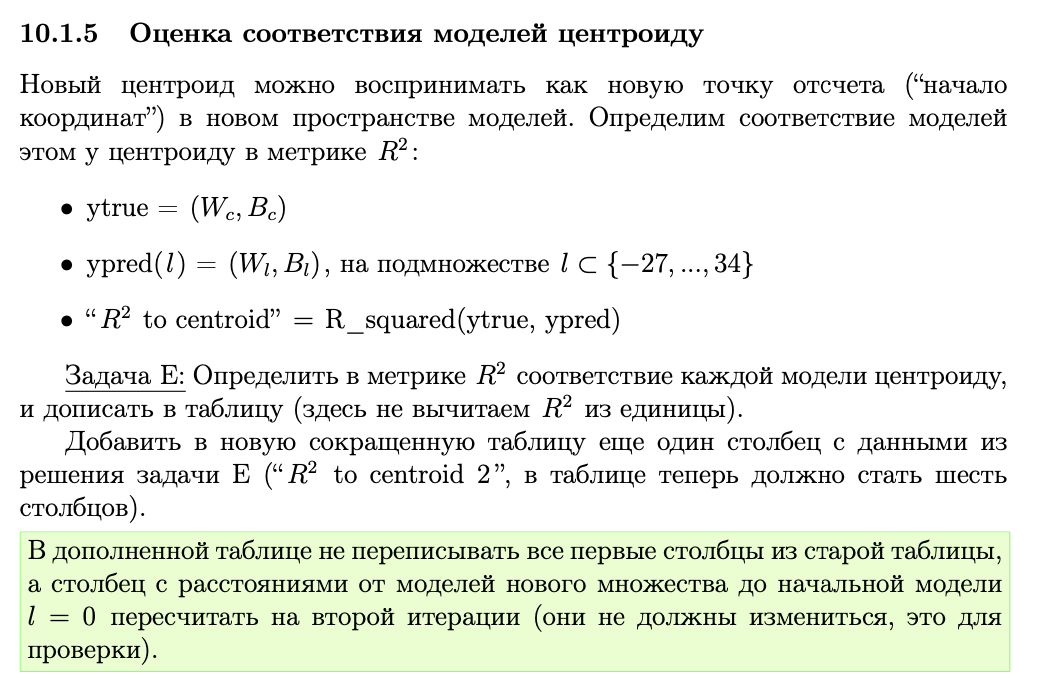

In [297]:
ytrue = Wc_list

r2_values = []
for l in models:
    result = models[l].groupby('Период').apply(calculate_levels).reset_index(drop=True)
    bw_list = result['BW'].tolist()
    ypred = [sublist[0] for sublist in bw_list]
    r2_values.append(r2_score(ytrue, ypred).round(4))

centroid_2.loc[:, 'R^2 to centroid 2'] = r2_values
centroid_2

/var/folders/lr/pb6gq9k51rx3x93_dcbnvjmr0000gn/T/ipykernel_7061/3032943232.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  centroid_2.loc[:, 'R^2 to centroid 2'] = r2_values


,"Model, l",Fit-error,dist between models = 1 - R^2,R^2 to centroid,R^2 to new centroid,R^2 to centroid 2
19,-21,0.1879,0.0565,0.9655,0.9548,0.9458
20,-20,0.1758,0.0330,0.9685,0.9686,0.9635
21,-19,0.1635,0.0305,0.9494,0.9584,0.9588
22,-18,0.1712,0.0318,0.9486,0.9568,0.9571
23,-17,0.1578,0.0234,0.9516,0.9587,0.9592
24,-16,0.1445,0.0182,0.9385,0.9538,0.9572
35,-5,0.0180,0.0158,0.9173,0.9554,0.9663
36,-4,0.0179,0.0098,0.9213,0.9566,0.9660
37,-3,0.0161,0.0111,0.9140,0.9522,0.9618
38,-2,0.0099,0.0055,0.9245,0.9582,0.9649


In [298]:
model0 = model_with_shift(0)

In [299]:
result = model0.groupby('Период').apply(calculate_levels).reset_index(drop=True)
bw_list = result['BW'].tolist()
ytrue = [sublist[0] for sublist in bw_list]

r2_values = []
for l in models:
    result = models[l].groupby('Период').apply(calculate_levels).reset_index(drop=True)
    bw_list = result['BW'].tolist()
    ypred = [sublist[0] for sublist in bw_list]
    r2_values.append(1 - r2_score(ytrue, ypred).round(4))

centroid_2.loc[:, 'dist'] = r2_values
centroid_2

/var/folders/lr/pb6gq9k51rx3x93_dcbnvjmr0000gn/T/ipykernel_7061/1512244078.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  centroid_2.loc[:, 'dist'] = r2_values


,"Model, l",Fit-error,dist between models = 1 - R^2,R^2 to centroid,R^2 to new centroid,R^2 to centroid 2,dist
19,-21,0.1879,0.0565,0.9655,0.9548,0.9458,0.0565
20,-20,0.1758,0.0330,0.9685,0.9686,0.9635,0.0330
21,-19,0.1635,0.0305,0.9494,0.9584,0.9588,0.0305
22,-18,0.1712,0.0318,0.9486,0.9568,0.9571,0.0318
23,-17,0.1578,0.0234,0.9516,0.9587,0.9592,0.0234
24,-16,0.1445,0.0182,0.9385,0.9538,0.9572,0.0182
35,-5,0.0180,0.0158,0.9173,0.9554,0.9663,0.0158
36,-4,0.0179,0.0098,0.9213,0.9566,0.9660,0.0098
37,-3,0.0161,0.0111,0.9140,0.9522,0.9618,0.0111
38,-2,0.0099,0.0055,0.9245,0.9582,0.9649,0.0055


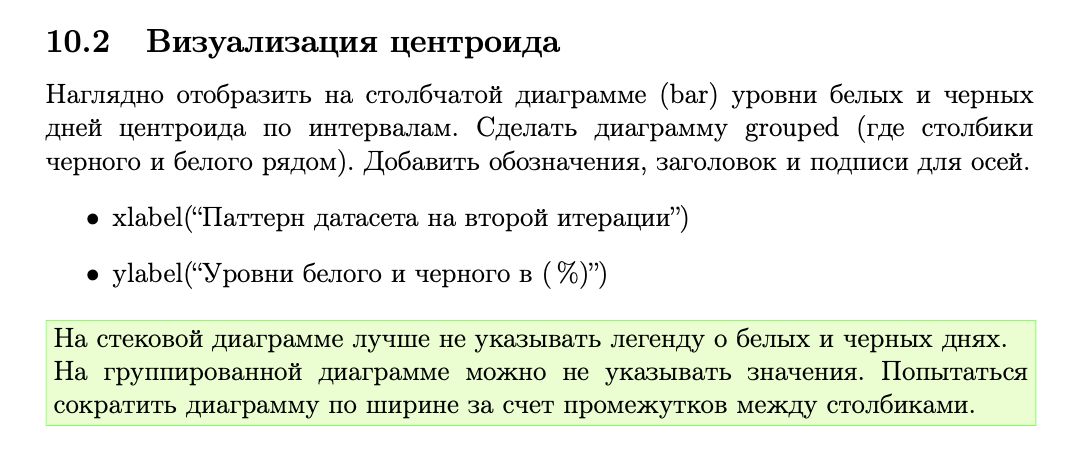

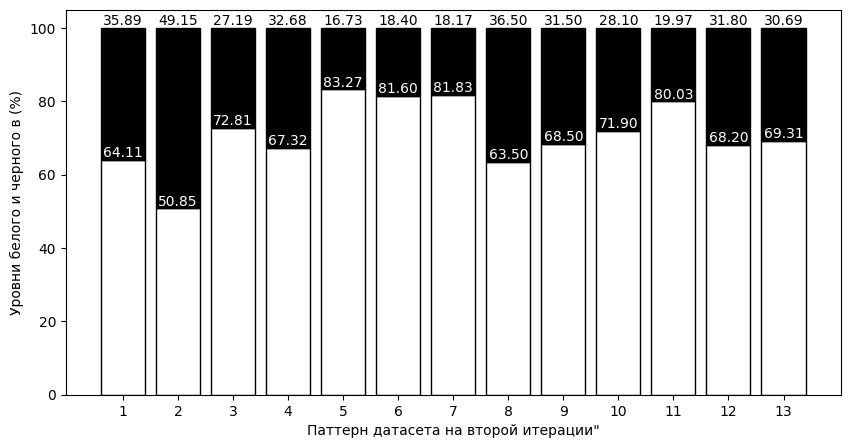

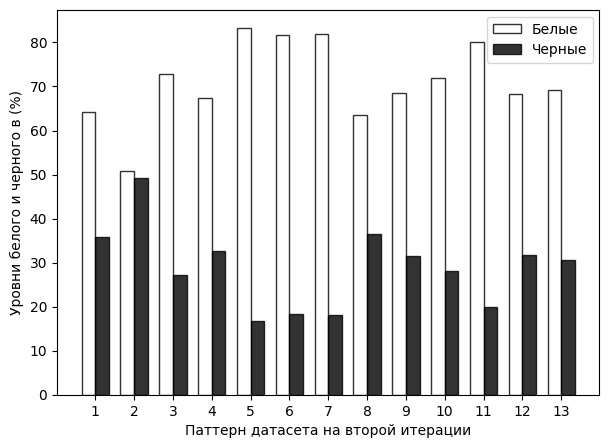

In [300]:

intervals = np.arange(1, len(Wc_list)+1)
# Стековая диаграмма
plt.figure(figsize=(10,5))
rects1 = plt.bar(intervals, Wc_list, color='white', edgecolor='black', label='Белые')
rects2 = plt.bar(intervals, Bc_list, color='black', edgecolor='black', label='Черные', bottom=Wc_list)
plt.xlabel('Паттерн датасета на второй итерации"')
plt.ylabel('Уровни белого и черного в (%)')
plt.xticks(intervals)

for rect, level in zip(rects1, Wc_list):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2., height,
             f'{level:.2f}',
             ha='center', va='bottom', color='white')

for rect, level in zip(rects2, Bc_list):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2., height + Wc_list[rects2.index(rect)],
             f'{level:.2f}',
             ha='center', va='bottom')

# Группированная диаграмма
plt.figure(figsize=(7,5))
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(intervals - bar_width/2, Wc_list, bar_width, alpha=opacity, color='white', edgecolor='black', label='Белые')
rects2 = plt.bar(intervals + bar_width/2, Bc_list, bar_width, alpha=opacity, color='black', edgecolor='black', label='Черные')

plt.xlabel('Паттерн датасета на второй итерации')
plt.ylabel('Уровни белого и черного в (%)')
plt.xticks(intervals)
plt.legend()

plt.show()
